# The Aiyagari Model in Continuous Time

### Intro

*note*: *you will need Julia 1.6 or higher to run this code*

This code solves for the stationary equilibrium of the Aiyagari model in continuous time. The code proceeds in three steps (i) solving for the HJB equation, (ii) using the transpose for the differential operator to solve for the KFE, and (iii) using a dampened bisection algorithm to solve for the market clearing interest rate.

We assume felicity takes the form

$$u(c) = \frac{c^{1-\gamma}}{1-\gamma}$$

and the logarithm of income follows an Ornstein-Uhlenbeck process:

$$ d\log (z) = \theta \log (z)dt + \sigma^2 dW$$

where $dW$ is a standard Wiener process. Note that these parameters should be estimated to match features (autocorrelation and variance) of idiosyncratic income returns.

### Background

This code builds upon the methods developed by Achdou et al. (2021) "Income and Wealth Distribution in Macroeconomics: A Continuous-Time Approach". I suggest you take a brief look at their [Numerical Appendix](https://benjaminmoll.com/wp-content/uploads/2020/02/HACT_Numerical_Appendix.pdfhttps://benjaminmoll.com/wp-content/uploads/2020/02/HACT_Numerical_Appendix.pdf) for a brief overview of the algorithm -- I have tried to make notation consistent with their paper. 

In discrete time, we relied on the powerful contraction mapping theorem to obtain convergence in policy functions. In continuous time, we obtain a partial differential equation that characterizes the optimal policy function, and no such general contraction mapping theorem for PDEs exists. We therefore need to construct a suitable approximation scheme to the PDE that will converge to the true solution. The appropriate solution concept is that of a **viscosity solution** (if the value function is not twice differentiable), and the scheme constructed is such so that it is guaranteed to converge to the (typically unique) viscosity solution of the system. This method is based upon Barles and Souganides in a 1991 [paper](https://benjaminmoll.com/wp-content/uploads/2021/04/barles-souganidis.pdfhttps://benjaminmoll.com/wp-content/uploads/2021/04/barles-souganidis.pdf). They show that any approximation system that satisfies three conditions will converge to the solution of a non-linear elliptic or parabolic PDE. These conditions are:

1. monotonicity (this is why we need backwards and forwards differences depending on the sign of the drift: it needs to preserve the **strong comparison principle** of viscosity solutions)
2. stability (the scheme has a solution which is uniformly bounded)
3. consistency (as the discretization tends to zero, the approximation becomes exact)

Fret not if these terms are unfamiliar. Both the paper by Barles-Souganides as well as this [introduction](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2396142&download=yeshttps://papers.ssrn.com/sol3/papers.cfm?abstract_id=2396142&download=yes) to the Barles-Souganides conditions by Agnes Tourin are quite accessible. These conditions demystify why we need to use the particular upwind scheme that we employ in this code. It also informs us what upwind schemes we should use to solve other stochastic control problems -- precisely those that satisfy the conditions above.

### Issues in Practice

There are two numerical issues that you might encounter when solving continuous time PDEs.

1. **Concavity**: in theory, the particular upwind scheme you will use depends on whether the value function is concave or not. In some cases, we can prove concavity of the value function (such as here). However, even though the value function is concave in theory, it tends not to be fully concave in practice. For example, in the HJB function, you will see that I commented out an assertion that throws an error when the discretized value function is not concave. Still, the numerical scheme seems to do well in practice and the policy functions are concave.

2. **Boundary conditions**: we need to impose certain boundary conditions to ensure that the forward difference is never used at the maximum of the grid space (because we do not have an additional grid point above), and the backward difference is not used at the lower boundary of that space (because we do not have an additional grid point below). When the discount rate is greater than the interest rate ($\rho>r$), we should never use the forward difference for the value function in THEORY. However, it tends to be used sometimes in practice. Still, it seems that the value function converges quickly and accurately.

In [1]:
using Parameters
using SparseArrays
import LinearAlgebra


hh = @with_kw (gamma = 2.0, # inverse elasticity
    alpha = 0.35, # F = K^alpha * L^(1-alpha) 
    delta = 0.1, # capital depreciation
    rho = 0.05, # discount rate
    corr = 0.9, # rate of change of correlation
    theta = -log(corr), # theta for OU process in logs
    J = 40, # number of income points
    var = 0.07, # unconditional variance of log-income
    zmean = exp(var/2), # unconditional mean of log-income
    OU_diff_sq = 2*theta*var, # diffusion term for OU in logs
    zmin = zmean*0.8, # min income
    zmax = zmean*1.2, # max income
    dz = (zmax - zmin)/(J-1), 
    amin = -0.02, # borrowing constraint
    amax = 30, # max asset
    I = 100, # number of apoints
    da = (amax-amin)/(I-1),
    agrid = range(amin, stop = amax, length = I), # asset grid
    zgrid = range(zmin, stop = zmax, length = J), # income grid
    z_mean = (-theta*(log.(zgrid)) .+ OU_diff_sq/2).*zgrid, # drift for income in levels for HJB
    z_var = OU_diff_sq.*(zgrid.^2), # diffusion of income in levels for HJB
    z_mat = ones(I,1)*zgrid', # mesh 
    a_mat = agrid*ones(1,J) # mesh
)

hh = hh()

(gamma = 2.0, alpha = 0.35, delta = 0.1, rho = 0.05, corr = 0.9, theta = 0.10536051565782628, J = 40, var = 0.07, zmean = 1.0356197087996233, OU_diff_sq = 0.01475047219209568, zmin = 0.8284957670396986, zmax = 1.242743650559548, dz = 0.01062174060307306, amin = -0.02, amax = 30, I = 100, da = 0.30323232323232324, agrid = -0.02:0.30323232323232324:30.0, zgrid = 0.8284957670396986:0.01062174060307306:1.242743650559548, z_mean = [0.022533541939414987, 0.021696178102538273, 0.020844647911799997, 0.01997912845590562, 0.019099792450662494, 0.01820680839898012, 0.017300340743158584, 0.016380550009924243, 0.015447592948639483, 0.014501622663083245  …  -0.008131597766586488, -0.009331167562660786, -0.010541004585951192, -0.011761015495445233, -0.012991108632019358, -0.014231193973385892, -0.01548118309063501, -0.016740989106301424, -0.01801052665388994, -0.019289711838796665], z_var = [0.010124801346166678, 0.010386075805625615, 0.010650678602147724, 0.010918609735733, 0.01118986920638145, 0.01

In [2]:
# get transition matrix for income (this does not depend on savings)
# so useful to only do it once

@unpack z_var, z_mean, dz, I, J, zgrid, amax, amin = hh

v = @. min(z_mean,0)/dz - max(z_mean,0)/dz - z_var/dz^2
chi = @. -min(z_mean,0)/dz + z_var/(2*dz^2)
zeta = @. max(z_mean,0)/dz + z_var/(2*dz^2)

updiag = zeros(I*J);
centdiag = zeros(I*J);
lowdiag = zeros(I*J);

for j = 1:J
    if j == 1
        centdiag[1:I] .= v[1] + chi[1]
    elseif j == J
        centdiag[I*(J-1)+1:I*J] .= v[J] + zeta[J]
        lowdiag[I*(J-1)+1:I*J] .= chi[J]
        updiag[I*(J-1)+1:I*J] .= zeta[J-1]
    else
        centdiag[I*(j-1)+1:I*j] .= v[j]
        lowdiag[I*(j-1)+1:I*j] .= chi[j]
        updiag[I*(j-1)+1:I*j] .= zeta[j-1]
    end
end

C = spdiagm(0 => centdiag, I => updiag[I+1:end], -I => lowdiag[I+1:end])


4000×4000 SparseMatrixCSC{Float64, Int64} with 11800 stored entries:
⢵⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⢗

In [3]:
function HJB(hh; v0, C, r, w, maxiter=50, delta = 1000)
    """
    ### Fields
    
    v0: initial guess for value function
    C: income transition matrix (if independent of savings)
    r: interest rate
    w: wage
    hh: household tuple
    
    ### Returns
    
    AC: differential operator (to use adjoint in KFE)
    v_new: converged value function
    c: consumption policy function
    
    """
    
    @unpack zgrid, amin, gamma, amax, z_mat, a_mat, da, dz, rho = hh
    
    v = v0
    Vf = zeros(I,J)
    Vb = zeros(I,J)
    
    for iter = 1:maxiter

    # forwards iteration
        
    Vf[1:I-1, :] = (v[2:I,:] .- v[1:I-1,:])./da
    Vf[I,:] = (w.*zgrid .+ r.*(amax)).^(-gamma) # changed upper boundary condition to make it less strict (r to rho)

    # backwards iteration
        
    Vb[2:I,:] = (v[2:I,:] - v[1:I-1,:])./da
    Vb[1,:] = (w.*zgrid .+ r.*amin).^(-gamma) # boundary condition

    # I_concave = Vb .> Vf # indicator (THIS WILL IN PRACTICE NEVER HOLD)

    cf = Vf.^(-1/gamma)
    sf = @. w*z_mat + r*a_mat - cf

    cb = Vb.^(-1/gamma)
    sb = @. w*z_mat + r*a_mat - cb

    c0 = @. w*z_mat + r*a_mat
    V0 = c0.^(-gamma)

    If = sf .> 0 # positive drift indicator
    Ib = sb .< 0 # negative drift indicator

    I0 = @. (1-If-Ib)

    V_up = Vf.*If + Vb.*Ib + V0.*I0
    c = V_up.^(-1/gamma)
    u = @. c^(1-gamma)/(1-gamma)

    # @assert sum(If[I,:]) == 0 && sum(1 .- Ib[I,:]) == 0 (THIS WILL IN PRACTICE NEVER HOLD)

    # see equation (35) in numerical appendix of paper for below
        
    X = @. -min(sb,0)/da;
    Y = @. -max(sf,0)/da + min(sb,0)/da;
    Z = @. max(sf,0)/da;

    updiag = zeros(I*J - 1);
    centdiag = zeros(I*J);
    lowdiag = zeros(I*J - 1);

    for j = 1:J
        centdiag[I*(j-1)+1:I*j] .= Y[:,j]
        lowdiag[I*(j-1)+1:I*j - 1] .= X[2:end, j]
        updiag[I*(j-1)+1:I*j - 1] .= Z[1:end-1, j]
    end

    A = spdiagm(0 => centdiag, 1 => updiag, -1 => lowdiag)

    # putting everything together
        
    AC = A + C

    B = (1/delta + rho).*LinearAlgebra.I(I*J) - AC
    b = vec(u + (1/delta)*v)

    v_new = reshape(B\b, (I, J))

    if maximum(abs.(v_new - v)) < 1e-5
        println("success with r = $r")
        println("number of iterations = $iter")
        return AC, v_new, c
    else
        v = v_new
    end
end
end


HJB (generic function with 1 method)

In [4]:
function KFE(hh; A)

    @unpack I, J, da, dz, agrid = hh

    AT = A'
    b = zeros(I*J,1);

    # fix one value to prevent matrix from being singular
    b[1] = 0.1;
    AT[1,1] = 1
    AT[1,2:end] .= 0

    # solve linear system
    gg = AT\b;
    g_sum = gg'*ones(I*J,1)*da*dz;
    gg = gg./g_sum;

    g = reshape(gg,I,J)

    # get aggregate capital
    K = sum(g'*agrid*da*dz)
    
    return g, K
end

KFE (generic function with 1 method)

In [5]:
function ss(hh; tol = 1e-5, maxit = 100, K0 = 3.725, relax = 0.99)
    @unpack alpha, delta, gamma, z_mat, a_mat, rho = hh
    
    K = K0
    
    for iter = 1:maxit
        
        r = alpha*K^(alpha-1) - delta # interest rate
        w = (1-alpha)*K^(alpha) # wages

        v0 = (w.*z_mat .+ r.*a_mat).^(1-gamma)./(rho*(1-gamma)) # initial guess is keep assets stationary
        AC, v_new , c = HJB(hh, w = w, r = r, v0 = v0, C = C)

        g, K_new = KFE(hh; A = AC)

            if abs(K - K_new) < tol
                return g, c, K
            else
                K = relax*K + (1-relax)*K_new
            end
    end
end


ss (generic function with 1 method)

In [6]:
_, c, K = ss(hh)

success with r = 0.0488798642898339
number of iterations = 5
success with r = 0.048874374790334824
number of iterations = 5
success with r = 0.04887356050492847
number of iterations = 5
success with r = 0.04887343580469547
number of iterations = 5
success with r = 0.04887341661925784
number of iterations = 5
success with r = 0.04887341366544365
number of iterations = 5


([0.5371141577651004 0.5448502306009559 … 0.07450730137882904 0.07142549915933089; 0.4252178128819586 0.43328830164602816 … 0.1451265932430228 0.13967906548662926; … ; 4.167138442804992e-7 4.2864544809935646e-7 … 6.494834895321292e-7 6.283760290802812e-7; 1.928559438596436e-7 1.9979352606329633e-7 … 6.886259110682987e-7 6.677129076817736e-7], [0.8523347809256171 0.8632746815563725 … 1.0521565713576173 1.0523313310519675; 0.9822883010284841 0.9829601361166744 … 1.0758893915395626 1.0760372812556316; … ; 2.509302661001942 2.5095375612646067 … 2.5936510920548477 2.594016080526565; 2.5294263881405317 2.5297028757794076 … 2.735230883130943 2.7461707837616984], 3.7252483147938023)

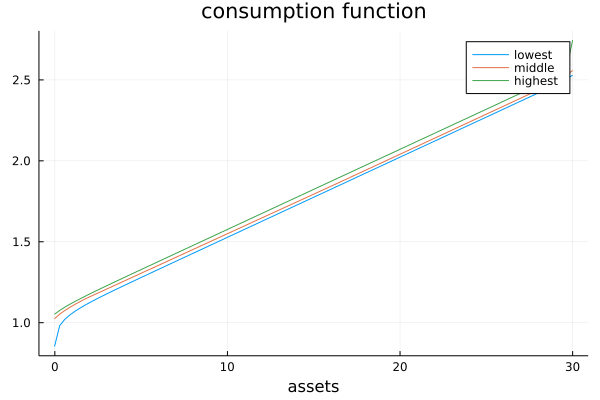

In [7]:
using Plots

@unpack agrid = hh

plot(agrid, [c[:,1] c[:,20] c[:,40]], title = "consumption function", xlabel = "assets", label = ["lowest" "middle" "highest"])

In [8]:
# plot asset supply and demand

@unpack z_mat, gamma, delta, alpha, a_mat, delta, rho = hh

r = collect(0.047:0.0001:0.0499)

K_s = @. ((r + delta)/alpha)^(1/(alpha -1))
w = @. (1-alpha)*K_s^(alpha)

K_d = similar(K_s)

for (i, r_i) in enumerate(r)

    v0 = (w[i].*z_mat .+ r_i.*a_mat).^(1-gamma)./(rho*(1-gamma)) # initial guess is keep assets stationary
    AC, _ , _ = HJB(hh, w = w[i], r = r_i, v0 = v0, C = C)

    _, K_new = KFE(hh; A = AC)
    K_d[i] = K_new
end
    

success with r = 0.047
number of iterations = 5
success with r = 0.0471
number of iterations = 5
success with r = 0.0472
number of iterations = 5
success with r = 0.0473
number of iterations = 5
success with r = 0.0474
number of iterations = 5
success with r = 0.0475
number of iterations = 5
success with r = 0.0476
number of iterations = 5
success with r = 0.0477
number of iterations = 5
success with r = 0.0478
number of iterations = 5
success with r = 0.0479
number of iterations = 5
success with r = 0.048
number of iterations = 5
success with r = 0.0481
number of iterations = 5
success with r = 0.0482
number of iterations = 5
success with r = 0.0483
number of iterations = 5
success with r = 0.0484
number of iterations = 5
success with r = 0.0485
number of iterations = 5
success with r = 0.0486
number of iterations = 5
success with r = 0.0487
number of iterations = 5
success with r = 0.0488
number of iterations = 5
success with r = 0.0489
number of iterations = 5
success with r = 0.049

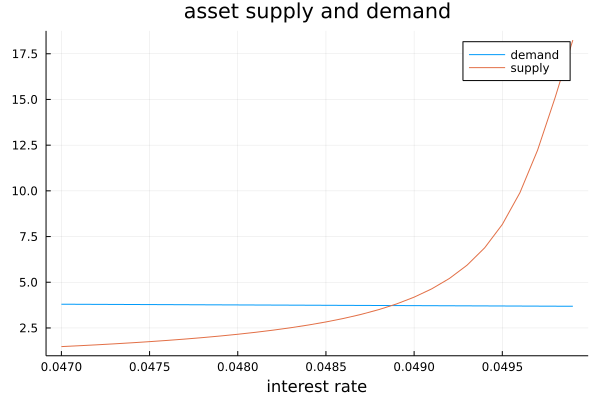

In [9]:
plot(r, K_s, label = "demand")
plot!(r, K_d, label = "supply")
title!("asset supply and demand")
xlabel!("interest rate")